## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import cleanlab
from cleanlab.rank import get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.internal.label_quality_utils import get_normalized_entropy
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, log_loss
from matplotlib import pyplot as plt
import copy

sys.path.insert(0, "../")
from eval_metrics import lift_at_k
from active_learning_scores import least_confidence

# experimental version of label quality ensemble scores with additional weighting schemes
from label_quality_ensemble_scores_experimental import get_label_quality_ensemble_scores_experimental

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### Models

In [2]:
models = [
    "resnet18",
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224",
]

### Dictionaries to map to display names

In [3]:
# dictionaries to map to display name

method_adjust_pred_probs_display_dict = {
    "self_confidence-False": "Self Confidence",
    "self_confidence-True": "Adjusted Self Confidence",
    "normalized_margin-False": "Normalized Margin",
    "normalized_margin-True": "Adjusted Normalized Margin",
    "confidence_weighted_entropy-False": "Confidence Weighted Entropy",
    "entropy-False": "Entropy",
    "least_confidence-False": "Least Confidence",
}

model_display_name_dict = {
    "swin_base_patch4_window7_224": "Swin Transformer",
    "twins_pcpvt_base": "Twins PCPVT",
    "efficientnet_b1": "EfficientNet-B1",
    "resnet50d": "ResNet-50d",
    "resnet18": "ResNet-18",
}

## Load files from experiments
**Note:** we can refactor the code later to make it more concise but for now it reads the .npy files for each dataset within the for-loop

In [4]:
%%time

experiments = []

for model in models:

    #### Andrew Ng DCAI Roman Numerals ####

    # read numpy files
    numpy_out_folder = f"./roman-numeral/roman-numeral_train_val_dataset_cv_{model}/"
    pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
    labels = np.load(numpy_out_folder + "labels.npy")
    images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)
    label_errors_mask = np.load(numpy_out_folder + "label_errors_mask.npy")

    # store results of experiment
    experiment_results = {
        "dataset": "roman-numeral",
        "model": model,
        "pred_probs": pred_probs,
        "labels": labels,
        "images": images,
        "label_errors_mask": label_errors_mask
    }
    experiments.append(experiment_results)


    #### Cifar-10n-worst

    # read numpy files
    numpy_out_folder = f"./cifar-10n-worst/cifar-10n-png_noise_type_worst_cv_{model}/"
    pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
    labels = np.load(numpy_out_folder + "noisy_labels.npy")
    true_labels = np.load(numpy_out_folder + "true_labels.npy")
    images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

    label_errors_mask = (true_labels != labels) # boolean mask of label errors

    # store results of experiment
    experiment_results = {
        "dataset": "cifar-10n-worst",
        "model": model,
        "pred_probs": pred_probs,
        "labels": labels,
        "images": images,
        "label_errors_mask": label_errors_mask
    }
    experiments.append(experiment_results)


    #### Cifar-10n-aggregate

    # read numpy files
    numpy_out_folder = f"./cifar-10n-aggregate/cifar-10n-png_noise_type_aggre_cv_{model}/"
    pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
    labels = np.load(numpy_out_folder + "noisy_labels.npy")
    true_labels = np.load(numpy_out_folder + "true_labels.npy")
    images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

    label_errors_mask = (true_labels != labels) # boolean mask of label errors

    # store results of experiment
    experiment_results = {
        "dataset": "cifar-10n-aggregate",
        "model": model,
        "pred_probs": pred_probs,
        "labels": labels,
        "images": images,
        "label_errors_mask": label_errors_mask    
    }
    experiments.append(experiment_results)


    #### Cifar-10

    # synthetic noise amount 20% and sparsity 40% (as defined in confident learning paper)

    # read numpy files
    numpy_out_folder = f"./cifar-10/cifar10_train_dataset_noise_amount_0.2_sparsity_0.4_cv_{model}/"
    pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
    labels = np.load(numpy_out_folder + "noisy_labels.npy")
    true_labels = np.load(numpy_out_folder + "true_labels.npy")
    images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

    label_errors_mask = (true_labels != labels) # boolean mask of label errors

    # store results of experiment
    experiment_results = {
        "dataset": "cifar-10",
        "model": model,
        "pred_probs": pred_probs,
        "labels": labels,
        "images": images,
        "label_errors_mask": label_errors_mask    
    }
    experiments.append(experiment_results)


    #### Food-101n

    # we only have verified labels for ~50K images so we have to evaluate within this subset

    # read numpy files
    numpy_out_folder = f"./food-101n/food-101n_cross_val/food-101n_cv_{model}/"
    pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
    labels = np.load(numpy_out_folder + "noisy_labels.npy")
    images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

    # read verified training labels
    path_verified_train = "./food-101n/verified_train.tsv"
    df_verified_train = pd.read_csv(path_verified_train, sep='\t')

    # instantiate DataFrame with all training data
    df_image_paths = pd.DataFrame({
        "class_name/key": pd.Series(images).map(lambda f: "/".join(Path(f).parts[-2:]))
    })

    # join to append verification_label column
    df_image_paths_w_verified = df_image_paths.merge(df_verified_train, on="class_name/key", how="left")

    # subset of data with verified labels
    verified_subset_mask = ~df_image_paths_w_verified.verification_label.isnull().values

    # filter on verified subset
    pred_probs = pred_probs[verified_subset_mask]
    labels = labels[verified_subset_mask]
    images = images[verified_subset_mask]

    # boolean mask of label errors
    label_errors_mask = df_image_paths_w_verified["verification_label"].values[verified_subset_mask] == 0

    # store results of experiment
    experiment_results = {
        "dataset": "food-101n",
        "model": model,
        "pred_probs": pred_probs,
        "labels": labels,
        "images": images,
        "label_errors_mask": label_errors_mask  
    }
    experiments.append(experiment_results)

CPU times: user 6.49 s, sys: 588 ms, total: 7.08 s
Wall time: 7.1 s


## Evaluate all results from individual models

In [5]:
from cleanlab.rank import get_label_quality_scores

def probability_mass_above_given_label_score(labels, pred_probs, method="self_confidence", adjust_pred_probs=False, alpha=.99):
    # self confidence
    self_confidence = get_label_quality_scores(labels, pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)
    # probability mass above given label
    mass_above_given_label = np.sum(np.clip(pred_probs - self_confidence[:,np.newaxis], a_min=0, a_max=None), axis=1)
    return (1 - mass_above_given_label) * alpha + (self_confidence) * (1 - alpha)

In [6]:
%%time

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

evaluations = []
precision_recall_curves = [] # store this separately
accuracy_list = []

for experiment in experiments:
    
    # experiment results
    dataset = experiment["dataset"]
    model = experiment["model"]
    pred_probs = experiment["pred_probs"]
    labels = experiment["labels"]
    images = experiment["images"]
    label_errors_target = experiment["label_errors_mask"]
    
    accuracy = {
        "dataset": dataset,
        "model": model,
        "cv_accuracy": (pred_probs.argmax(axis=1) == labels).mean()
    }
    
    accuracy_list.append(accuracy)
    
    #### label quality scoring
    
    for score_param in score_params:
        
        # label quality scoring method
        method, adjust_pred_probs = score_param    
    
        # compute scores
        label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)
        
        # lift at K where K = number of label errors
        lift_at_num_label_errors = lift_at_k(label_errors_target, 1 - label_quality_scores, k=label_errors_target.sum())
        
        # lift at k=100
        lift_at_100 = lift_at_k(label_errors_target, 1 - label_quality_scores, k=100)
        
        # mass above given label score
        mass_above_given_label = probability_mass_above_given_label_score(labels, pred_probs, method=method, adjust_pred_probs=adjust_pred_probs, alpha=.99)
        # compute accuracy of detecting label errors using MAGL
        auroc_magl = roc_auc_score(label_errors_target, 1 - mass_above_given_label)

        evaluation_results = {
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset,
            "model": model,
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc,
            "lift_at_num_label_errors": lift_at_num_label_errors,
            "lift_at_100": lift_at_100,
            "mass_above_given_label": auroc_magl,
        }

        # store evaluation results
        evaluations.append(evaluation_results)
        

        # compute precision-recall curve using label quality scores
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)        
        
        precision_recall_curve_results = {
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset,
            "model": model,
            "label_quality_scores": label_quality_scores,
            "precision": precision,
            "recall": recall,
            "thresholds": thresholds
        }
        
        # store precision-recall curve results
        precision_recall_curves.append(precision_recall_curve_results)
        

    #### active learning scores to use as comparison
    
    al_scoring_funcs = {
        "entropy": get_normalized_entropy,
        "least_confidence": least_confidence
    }
    
    for al_method in al_scoring_funcs.keys():
        
        # active learning scoring function
        scoring_func = al_scoring_funcs[al_method]
    
        # score
        al_scores = scoring_func(pred_probs)

        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, al_scores)

        # lift at K where K = number of label errors
        lift_at_num_label_errors = lift_at_k(label_errors_target, al_scores, k=label_errors_target.sum())
        
        # lift at k=100
        lift_at_100 = lift_at_k(label_errors_target, al_scores, k=100)
        

        evaluation_results = {
            "method": al_method,
            "adjust_pred_probs": False,
            "dataset": dataset,
            "model": model,
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc,
            "lift_at_num_label_errors": lift_at_num_label_errors,
            "lift_at_100": lift_at_100,
        }

        # store evaluation results
        evaluations.append(evaluation_results)

CPU times: user 1min 22s, sys: 600 ms, total: 1min 23s
Wall time: 1min 23s


In [7]:
# cross-validation accuracy
df_cv_accuracy = pd.DataFrame(accuracy_list)

df_cv_accuracy_pivot = (
    pd.pivot_table(
        df_cv_accuracy, values="cv_accuracy", index=["model"], columns=["dataset"]
    )
    .reset_index()
    .sort_values(by="roman-numeral", ascending=False)
)

df_cv_accuracy_pivot["model"] = df_cv_accuracy_pivot.model.map(
    lambda x: model_display_name_dict[x]
)


In [8]:
df_cv_accuracy_pivot

dataset,model,cifar-10,cifar-10n-aggregate,cifar-10n-worst,food-101n,roman-numeral
3,Swin Transformer,0.79048,0.90628,0.60592,0.726805,0.821971
4,Twins PCPVT,0.78098,0.89714,0.60154,0.682694,0.816319
1,ResNet-18,0.73976,0.87448,0.57788,0.612291,0.783116
0,EfficientNet-B1,0.73582,0.87154,0.58040,0.627140,0.711409
2,ResNet-50d,0.75506,0.87878,0.59190,0.628748,0.708937


In [9]:
df_cv_accuracy.head()

,dataset,model,cv_accuracy
0,roman-numeral,resnet18,0.783116
1,cifar-10n-worst,resnet18,0.577880
2,cifar-10n-aggregate,resnet18,0.874480
3,cifar-10,resnet18,0.739760
4,food-101n,resnet18,0.612291


In [10]:
# master table with AUROC and Lift at K evaluation metrics for all methods, datasets, and models
df_evaluations = pd.DataFrame(evaluations)

# append cv accuracy
df_evaluations = df_evaluations.merge(df_cv_accuracy, how="left", on=["dataset", "model"])

In [11]:
df_evaluations["method_adjust_pred_probs"] = (
    df_evaluations.method + "-" + df_evaluations.adjust_pred_probs.astype(str)
)
df_evaluations["dataset_model"] = df_evaluations.dataset + " | " + df_evaluations.model

df_evaluations["scoring_method"] = df_evaluations.method_adjust_pred_probs.map(
    lambda x: method_adjust_pred_probs_display_dict[x]
)
df_evaluations["model_name"] = df_evaluations.model.map(
    lambda x: model_display_name_dict[x]
)


df_evaluations["model_name_w_acc"] = df_evaluations.model_name + " (" + df_evaluations.cv_accuracy.round(4).astype(str) + ") "

In [12]:
# df_evaluations.to_csv("evaluation_all_experiments.csv")
df_evaluations.head(10)

,method,adjust_pred_probs,dataset,model,dataset_num_samples,dataset_num_label_errors,auroc,lift_at_num_label_errors,lift_at_100,mass_above_given_label,cv_accuracy,method_adjust_pred_probs,dataset_model,scoring_method,model_name,model_name_w_acc
0,self_confidence,False,roman-numeral,resnet18,2831,372,0.812958,3.825565,5.935968,0.807268,0.783116,self_confidence-False,roman-numeral | resnet18,Self Confidence,ResNet-18,ResNet-18 (0.7831)
1,self_confidence,True,roman-numeral,resnet18,2831,372,0.817624,3.968768,5.707661,0.497350,0.783116,self_confidence-True,roman-numeral | resnet18,Adjusted Self Confidence,ResNet-18,ResNet-18 (0.7831)
2,normalized_margin,False,roman-numeral,resnet18,2831,372,0.803109,3.539159,4.261720,0.797713,0.783116,normalized_margin-False,roman-numeral | resnet18,Normalized Margin,ResNet-18,ResNet-18 (0.7831)
3,normalized_margin,True,roman-numeral,resnet18,2831,372,0.804237,3.477786,4.109516,0.386935,0.783116,normalized_margin-True,roman-numeral | resnet18,Adjusted Normalized Margin,ResNet-18,ResNet-18 (0.7831)
4,confidence_weighted_entropy,False,roman-numeral,resnet18,2831,372,0.810511,3.846023,6.012070,0.754031,0.783116,confidence_weighted_entropy-False,roman-numeral | resnet18,Confidence Weighted Entropy,ResNet-18,ResNet-18 (0.7831)
5,entropy,False,roman-numeral,resnet18,2831,372,0.732535,2.679941,3.576801,NaN,0.783116,entropy-False,roman-numeral | resnet18,Entropy,ResNet-18,ResNet-18 (0.7831)
6,least_confidence,False,roman-numeral,resnet18,2831,372,0.727816,2.598111,3.196290,NaN,0.783116,least_confidence-False,roman-numeral | resnet18,Least Confidence,ResNet-18,ResNet-18 (0.7831)
7,self_confidence,False,cifar-10n-worst,resnet18,50000,20104,0.963435,2.173462,2.487067,0.966931,0.577880,self_confidence-False,cifar-10n-worst | resnet18,Self Confidence,ResNet-18,ResNet-18 (0.5779)
8,self_confidence,True,cifar-10n-worst,resnet18,50000,20104,0.956146,2.148844,2.487067,0.800265,0.577880,self_confidence-True,cifar-10n-worst | resnet18,Adjusted Self Confidence,ResNet-18,ResNet-18 (0.5779)
9,normalized_margin,False,cifar-10n-worst,resnet18,50000,20104,0.966803,2.196967,2.487067,0.964611,0.577880,normalized_margin-False,cifar-10n-worst | resnet18,Normalized Margin,ResNet-18,ResNet-18 (0.5779)


### Just auroc values

In [13]:
df_evaluations_auroc = (
    pd.pivot_table(
        df_evaluations,
        values="auroc",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

df_evaluations_lift_at_num_errors = (
    pd.pivot_table(
        df_evaluations,
        values="lift_at_num_label_errors",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

df_evaluations_lift_at_100 = (
    pd.pivot_table(
        df_evaluations,
        values="lift_at_100",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

In [14]:
df_evaluations_auroc.tail()

scoring_method,dataset,model_name,model_name_w_acc,Adjusted Normalized Margin,Adjusted Self Confidence,Confidence Weighted Entropy,Entropy,Least Confidence,Normalized Margin,Self Confidence
20,roman-numeral,EfficientNet-B1,EfficientNet-B1 (0.7114),0.764783,0.791704,0.792893,0.716652,0.702276,0.763820,0.788765
21,roman-numeral,ResNet-18,ResNet-18 (0.7831),0.804237,0.817624,0.810511,0.732535,0.727816,0.803109,0.812958
22,roman-numeral,ResNet-50d,ResNet-50d (0.7089),0.763896,0.792971,0.790047,0.711257,0.692030,0.762171,0.788761
23,roman-numeral,Swin Transformer,Swin Transformer (0.822),0.821768,0.837348,0.836609,0.771631,0.762016,0.824684,0.834956
24,roman-numeral,Twins PCPVT,Twins PCPVT (0.8163),0.808794,0.821577,0.822917,0.743528,0.738774,0.814955,0.823612


In [15]:
df_evaluations_auroc

scoring_method,dataset,model_name,model_name_w_acc,Adjusted Normalized Margin,Adjusted Self Confidence,Confidence Weighted Entropy,Entropy,Least Confidence,Normalized Margin,Self Confidence
0,cifar-10,EfficientNet-B1,EfficientNet-B1 (0.7358),0.995089,0.987943,0.994679,0.389111,0.399475,0.994590,0.996415
1,cifar-10,ResNet-18,ResNet-18 (0.7398),0.995232,0.990242,0.995044,0.395634,0.405044,0.995195,0.996882
2,cifar-10,ResNet-50d,ResNet-50d (0.7551),0.996745,0.991531,0.996068,0.366274,0.378824,0.996162,0.997504
3,cifar-10,Swin Transformer,Swin Transformer (0.7905),0.999304,0.997663,0.999341,0.354074,0.363667,0.999105,0.999580
4,cifar-10,Twins PCPVT,Twins PCPVT (0.781),0.998234,0.995096,0.998338,0.332624,0.342802,0.997593,0.998797
5,cifar-10n-aggregate,EfficientNet-B1,EfficientNet-B1 (0.8715),0.974840,0.973098,0.970977,0.707042,0.715163,0.975452,0.975116
6,cifar-10n-aggregate,ResNet-18,ResNet-18 (0.8745),0.976235,0.975124,0.973501,0.718991,0.724296,0.977165,0.977300
7,cifar-10n-aggregate,ResNet-50d,ResNet-50d (0.8788),0.979087,0.978620,0.977013,0.710528,0.718418,0.979807,0.979977
8,cifar-10n-aggregate,Swin Transformer,Swin Transformer (0.9063),0.995509,0.995029,0.995070,0.757245,0.761292,0.996046,0.995753
9,cifar-10n-aggregate,Twins PCPVT,Twins PCPVT (0.8971),0.988455,0.987956,0.987392,0.752020,0.755311,0.988616,0.988539


## AUROC Plots
AUROC for LED achieved by label quality scores for each dataset and model. Models are ordered by accuracy on each dataset.

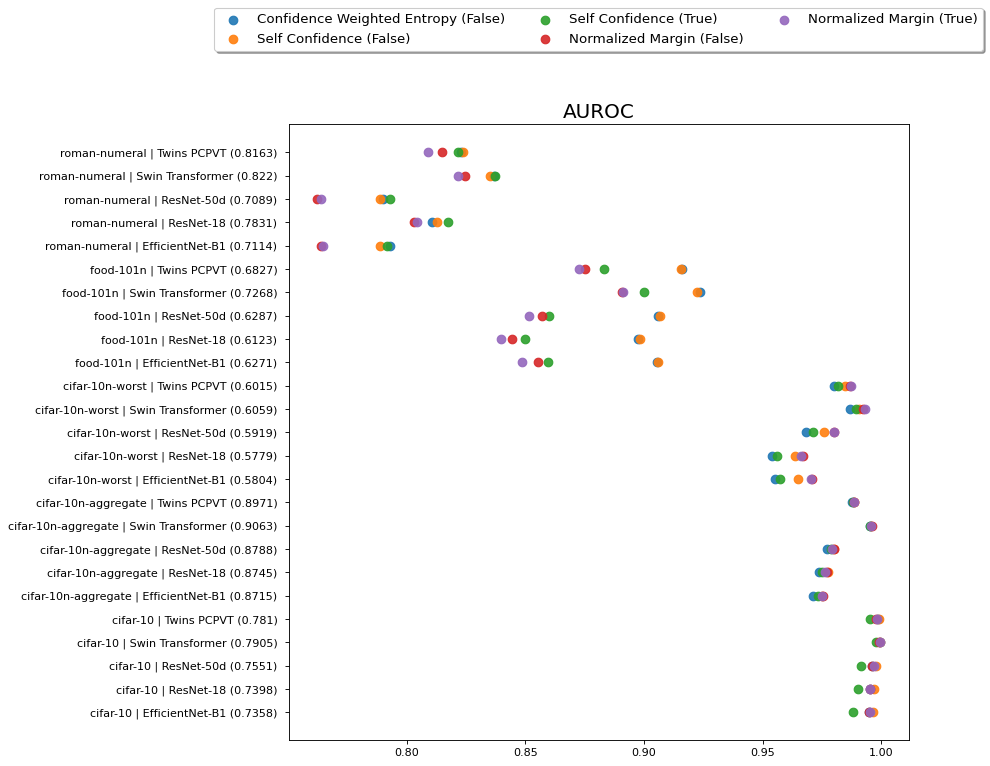

In [22]:
# pointer
df = df_evaluations_auroc
df['dataset_model'] = df.apply(lambda x: x['dataset'] + ' | ' + x['model_name_w_acc'],axis=1)

# Draw plot
plt.figure(figsize=(10, 10), dpi=80)

s = 60
alpha = 0.9
marker = "o"

s0 = plt.scatter(
    df["Confidence Weighted Entropy"], df.index, s=s, alpha=alpha, marker=marker
)
s1 = plt.scatter(df["Self Confidence"], df.index, s=s, alpha=alpha, marker=marker)
s2 = plt.scatter(df["Adjusted Self Confidence"], df.index, s=s, alpha=alpha, marker=marker)
s3 = plt.scatter(
    df["Normalized Margin"], df.index, s=s, alpha=alpha, marker=marker
)
s4 = plt.scatter(
    df["Adjusted Normalized Margin"], df.index, s=s, alpha=alpha, marker=marker
)
# s5 = plt.scatter(df["entropy-False"], df.index, s=s, alpha=alpha, marker=marker)
# s6 = plt.scatter(df["least_confidence-False"], df.index, s=s, alpha=alpha, marker=marker)

# for x, y, tex in zip(df["confidence_weighted_entropy-False"], df.index, df["confidence_weighted_entropy-False"]):
#     t = plt.text(x, y, round(tex, 1), horizontalalignment='center',
#                  verticalalignment='center', fontdict={'color':'white'})

plt.title("AUROC", fontsize=18)
plt.yticks(df.index, df.dataset_model)
plt.legend(
    (s0, s1, s2, s3, s4),
    (
        "Confidence Weighted Entropy (False)",
        "Self Confidence (False)",
        "Self Confidence (True)",
        "Normalized Margin (False)",
        "Normalized Margin (True)",
    ),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.2),
    ncol=3,
    fancybox=True,
    shadow=True,
    fontsize=12,
)


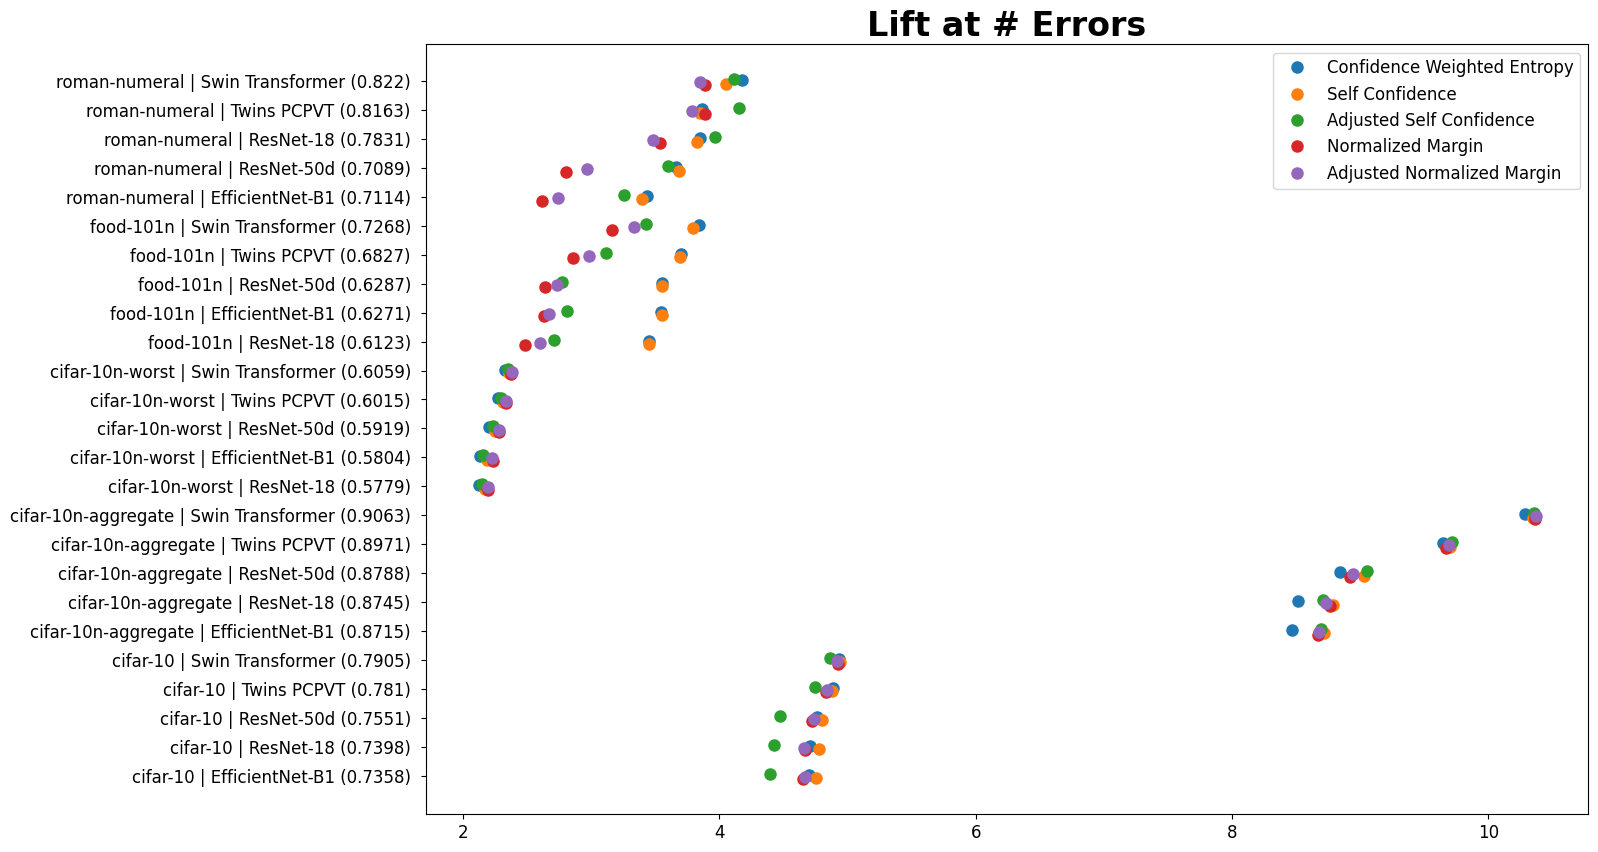

In [23]:
title = "Lift at # Errors"

# pointer
df = df_evaluations_lift_at_num_errors.sort_values(by=["dataset", "Self Confidence"])
df["dataset_model"] = df.dataset + " | " + df.model_name_w_acc

labels = df["dataset_model"].tolist()
x = np.arange(len(labels))  # the label locations

s0 = df["Confidence Weighted Entropy"].tolist()
s1 = df["Self Confidence"].tolist()
s2 = df["Adjusted Self Confidence"].tolist()
s3 = df["Normalized Margin"].tolist()
s4 = df["Adjusted Normalized Margin"].tolist()


jf = 0.15 # jitter factor
markersize = 8
alpha = 1

fig, ax = plt.subplots()
_ = ax.plot(s0, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Confidence Weighted Entropy", markersize=markersize, alpha=alpha)
_ = ax.plot(s1, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Self Confidence", markersize=markersize, alpha=alpha)
_ = ax.plot(s2, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Self Confidence", markersize=markersize, alpha=alpha)
_ = ax.plot(s3, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Normalized Margin", markersize=markersize, alpha=alpha)
_ = ax.plot(s4, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Normalized Margin", markersize=markersize, alpha=alpha)

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_xlabel("")
ax.set_title(title, fontsize=24, fontweight="bold")
ax.set_yticks(x, labels)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
# fig.tight_layout()
plt.show()

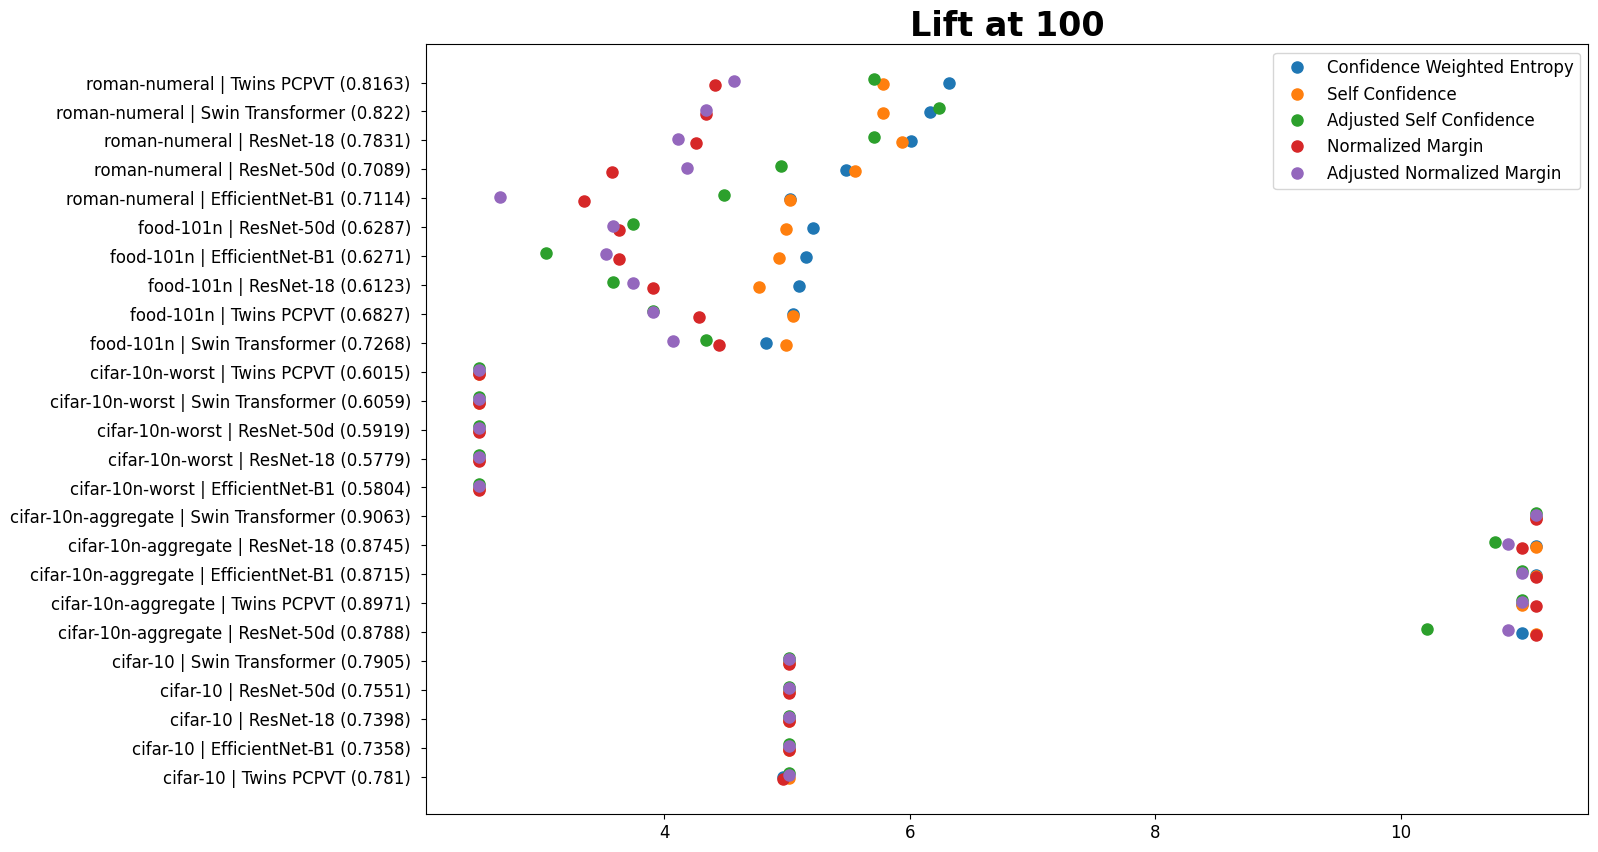

In [24]:
title = "Lift at 100"

# pointer
df = df_evaluations_lift_at_100.sort_values(by=["dataset", "Confidence Weighted Entropy"])
df["dataset_model"] = df.dataset + " | " + df.model_name_w_acc

labels = df["dataset_model"].tolist()
x = np.arange(len(labels))  # the label locations

s0 = df["Confidence Weighted Entropy"].tolist()
s1 = df["Self Confidence"].tolist()
s2 = df["Adjusted Self Confidence"].tolist()
s3 = df["Normalized Margin"].tolist()
s4 = df["Adjusted Normalized Margin"].tolist()


jf = 0.15 # jitter factor
markersize = 8
alpha = 1

fig, ax = plt.subplots()
_ = ax.plot(s0, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Confidence Weighted Entropy", markersize=markersize, alpha=alpha)
_ = ax.plot(s1, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Self Confidence", markersize=markersize, alpha=alpha)
_ = ax.plot(s2, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Self Confidence", markersize=markersize, alpha=alpha)
_ = ax.plot(s3, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Normalized Margin", markersize=markersize, alpha=alpha)
_ = ax.plot(s4, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Normalized Margin", markersize=markersize, alpha=alpha)

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_xlabel("")
ax.set_title(title, fontsize=24, fontweight="bold")
ax.set_yticks(x, labels)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
# fig.tight_layout()
plt.show()

### Precision/recall curves

In [28]:
plt.rcParams["figure.figsize"] = (15, 10)

df_list = []

for data in precision_recall_curves:

    # get data needed to plot precision-recall curve
    method = data["method"]
    adjust_pred_probs = data["adjust_pred_probs"]
    dataset = data["dataset"]
    model = data["model"]
    label_quality_scores = data["label_quality_scores"]
    precision = data["precision"]
    recall = data["recall"]
    thresholds = data["thresholds"]

    # save to DataFrame
    # ignore last precision, recall value because it's always 1, 0 respectively with no corresponding threshold
    # https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi
    df_temp = pd.DataFrame(
        {
            "precision": precision[:-1],
            "recall": recall[:-1],
            "thresholds": thresholds,
            "model": model,
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
        }
    )

    df_list.append(df_temp)

In [35]:
for data in df_list:
    precision = data["precision"]
    recall = data["recall"]
    method = data["method"]
    adjust_pred_probs = data["adjust_pred_probs"]
    plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}")

# TODO: Figure this out

# # plot single dot (precision, recall) for each filter_by option
# for index, row in df_filter_by.iterrows():
#     filter_by = row["filter_by"]
#     precision = row["precision"]
#     recall = row["recall"]
#     plt.plot(recall, precision, marker="o", markersize=10, label=filter_by)

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve: Label Error Detection on CIFAR-10N-Worst \n Model: swin_base_patch4_window7_224", fontsize=20, fontweight="bold")
# plt.suptitle("")
plt.legend()
plt.show()

KeyboardInterrupt: 

## Evaluate results from ensemble models
### Prepare data

In [36]:
%%time

dataset_model_output = {}

for i, experiment in enumerate(experiments):

    # experiment results
    dataset = experiment["dataset"]
    model = experiment["model"]
    pred_probs = experiment["pred_probs"]
    labels = experiment["labels"]
    images = experiment["images"]
    label_errors_target = experiment["label_errors_mask"]

    # check
    if dataset not in dataset_model_output.keys():

        # init list of pred_probs and labels
        dataset_model_output[dataset] = {}
        dataset_model_output[dataset]["pred_probs_list"] = []
        dataset_model_output[dataset]["labels_list"] = []
        dataset_model_output[dataset]["images_list"] = []
        dataset_model_output[dataset]["label_errors_target_list"] = []

    # store model output on dataset as key
    dataset_model_output[dataset]["pred_probs_list"].append(pred_probs)
    dataset_model_output[dataset]["labels_list"].append(labels)
    dataset_model_output[dataset]["images_list"].append(images)
    dataset_model_output[dataset]["label_errors_target_list"].append(
        label_errors_target
    )

CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 43.6 µs


### Evaluate ensemble models

In [37]:
%%time

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]


ensemble_evaluations = []

dataset_best_weights = []

for dataset_key in dataset_model_output.keys():

    # get list of pred_probs, labels for dataset
    pred_probs_list = dataset_model_output[dataset_key]["pred_probs_list"]
    labels_list = dataset_model_output[dataset_key]["labels_list"]
    images_list = dataset_model_output[dataset_key]["images_list"]
    label_errors_target_list = dataset_model_output[dataset_key]["label_errors_target_list"]
    
    # use for sanity check (noisy labels and images from each model should be the same because they were generated from the same cross-val procedure
    for i, (labels_temp, images_temp) in enumerate(zip(labels_list, images_list)):

        if i == 0:
            labels_temp_previous = copy.deepcopy(labels_temp)
            images_temp_previous = copy.deepcopy(images_temp)       
        else:
            assert (labels_temp_previous == labels_temp).all()
            assert (images_temp_previous == images_temp).all()    
    
    # take the first (the others are the same)
    labels = labels_list[0]
    label_errors_target = label_errors_target_list[0]
    
    # compute accuracy
    accuracy_list = []
    for pred_probs in pred_probs_list:
        
        # accuracy of single model
        accuracy = (pred_probs.argmax(axis=1) == labels).mean()
        accuracy_list.append(accuracy)
        
    # accuracy weights
    acc_weights = np.array(accuracy_list) / sum(accuracy_list)    
    
    # average predictions
    pred_probs_avg = sum(pred_probs_list) / len(pred_probs_list)
    
    #### can refactor below to a function that accepts weights and pred_probs_list
    
    # accuracy-weighted predictions
    pred_probs_avg_acc_weighted = sum([acc_weights[i] * p for i, p in enumerate(pred_probs_list)])
    

    #### find best t in T for exp-log-loss weighting
    T = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 2e2]

    pred_probs_avg_log_loss_weighted = None
    inv_log_loss_weights = None
    best_eval_log_loss = float("inf")
    best_t = None

    for t in T:

        log_loss_list = []

        # pred_probs for each model
        for pred_probs in pred_probs_list:
            log_loss_ = np.exp(t * (-log_loss(labels, pred_probs)))
            log_loss_list.append(log_loss_)

        # weights using log loss
        inv_log_loss_weights_temp = np.array(log_loss_list) / sum(log_loss_list)

        # weighted average
        pred_probs_avg_log_loss_weighted_temp = sum([inv_log_loss_weights_temp[i] * p for i, p in enumerate(pred_probs_list)])

        # evaluate log_loss with this weighted average
        eval_log_loss = log_loss(labels, pred_probs_avg_log_loss_weighted_temp)

        # check if this is the best eval_log_loss so far
        if best_eval_log_loss > eval_log_loss:
            best_eval_log_loss = eval_log_loss
            best_t = t
            pred_probs_avg_log_loss_weighted = pred_probs_avg_log_loss_weighted_temp.copy()
            inv_log_loss_weights = inv_log_loss_weights_temp.copy()    

    df_temp = pd.DataFrame({
        "dataset": dataset_key,
        "models": models,
        "best_t": best_t,
        "best_eval_log_loss": best_eval_log_loss,
        "inv_log_loss_weights": inv_log_loss_weights,
    })
    
    # save the weights for analysis later
    dataset_best_weights.append(df_temp)
            
    print()
    print(dataset_key)
    print(best_eval_log_loss)
    print(inv_log_loss_weights)
    print(pred_probs_avg_log_loss_weighted)
    
    
    #### label quality scoring
    
    for score_param in score_params:
        
        # label quality scoring method
        method, adjust_pred_probs = score_param
    
        # compute scores
        
        # use average pred_probs
        label_quality_scores_avg = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg, method=method, adjust_pred_probs=adjust_pred_probs)
        
        # use average pred_probs weighted by accuracy
        label_quality_scores_avg_acc_weighted = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg_acc_weighted, method=method, adjust_pred_probs=adjust_pred_probs)
        
        # use average pred_probs weighted by log loss
        label_quality_scores_avg_log_loss_weighted = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg_log_loss_weighted, method=method, adjust_pred_probs=adjust_pred_probs)
        
        # use pred_probs_list (weighted by accuracy)
        label_quality_scores_agg_acc = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs, 
            verbose=0,
            weight_ensemble_members_by="accuracy"
        )

        # use pred_probs_list (uniform_weights)
        label_quality_scores_agg_uni = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs,
            verbose=0,
            weight_ensemble_members_by="uniform"
        )
        
        # use pred_probs_list (weight by inverse log loss)
        label_quality_scores_agg_log_loss = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs,
            verbose=0, 
            weight_ensemble_members_by="custom",
            custom_weights=inv_log_loss_weights # custom weights!
        )        
        
        # compute accuracy of detecting label errors
        auroc_avg = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg)
        auroc_avg_acc_weighted = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg_acc_weighted)
        auroc_avg_log_loss_weighted = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted)        
        
        auroc_agg_acc = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_acc)
        auroc_agg_uni = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_uni)
        auroc_agg_log_loss = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_log_loss)        
        
        # lift at K where K = number of label errors
        lift_at_num_label_errors_avg = lift_at_k(label_errors_target, 1 - label_quality_scores_avg, k=label_errors_target.sum())
        lift_at_num_label_errors_avg_acc_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_acc_weighted, k=label_errors_target.sum())
        lift_at_num_label_errors_avg_log_loss_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted, k=label_errors_target.sum())
        
        lift_at_num_label_errors_agg_acc = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_acc, k=label_errors_target.sum())
        lift_at_num_label_errors_agg_uni = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_uni, k=label_errors_target.sum())
        lift_at_num_label_errors_agg_log_loss = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_log_loss, k=label_errors_target.sum())        
        
        # lift at k=100
        lift_at_100_avg = lift_at_k(label_errors_target, 1 - label_quality_scores_avg, k=100)
        lift_at_100_avg_acc_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_acc_weighted, k=100)
        lift_at_100_avg_log_loss_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted, k=100)
        
        lift_at_100_agg_acc = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_acc, k=100)
        lift_at_100_agg_uni = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_uni, k=100)
        lift_at_100_agg_log_loss = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_log_loss, k=100)

        ensemble_evaluation_results_avg = {
            "ensemble_method": "avg_pred_probs",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg,
            "lift_at_100": lift_at_100_avg
        }
        
        ensemble_evaluation_results_avg_acc_weighted = {
            "ensemble_method": "avg_pred_probs_weighted_by_accuracy",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg_acc_weighted,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg_acc_weighted,
            "lift_at_100": lift_at_100_avg_acc_weighted
        }        
        
        ensemble_evaluation_results_avg_log_loss_weighted = {
            "ensemble_method": "avg_pred_probs_weighted_by_inv_log_loss",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg_log_loss_weighted,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg_log_loss_weighted,
            "lift_at_100": lift_at_100_avg_log_loss_weighted
        }                
        
        ensemble_evaluation_results_agg_acc = {
            "ensemble_method": "avg_scores_weighted_by_accuracy",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_acc,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_acc,
            "lift_at_100": lift_at_100_agg_acc
        }
        
        ensemble_evaluation_results_agg_uni = {
            "ensemble_method": "avg_scores",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_uni,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_uni,
            "lift_at_100": lift_at_100_agg_uni
        }
        
        ensemble_evaluation_results_agg_log_loss = {
            "ensemble_method": "avg_scores_weighted_by_inv_log_loss",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_log_loss,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_log_loss,
            "lift_at_100": lift_at_100_agg_log_loss
        }
        
        # store evaluation results
        ensemble_evaluations.append(ensemble_evaluation_results_avg)
        ensemble_evaluations.append(ensemble_evaluation_results_avg_acc_weighted)
        ensemble_evaluations.append(ensemble_evaluation_results_avg_log_loss_weighted)
        
        ensemble_evaluations.append(ensemble_evaluation_results_agg_acc)
        ensemble_evaluations.append(ensemble_evaluation_results_agg_uni)
        ensemble_evaluations.append(ensemble_evaluation_results_agg_log_loss)


roman-numeral
0.5979558920023186
[0.16449406 0.01633022 0.02643896 0.33656737 0.45616939]
[[0.94851138 0.00349555 0.00809111 ... 0.00456724 0.00397106 0.0154217 ]
 [0.95787331 0.0067729  0.00853612 ... 0.00197562 0.00252046 0.01015361]
 [0.92717992 0.01712202 0.01467846 ... 0.00356716 0.00844771 0.00317639]
 ...
 [0.00893533 0.00662397 0.01020265 ... 0.00556751 0.04286358 0.90533814]
 [0.02452476 0.03145028 0.02143179 ... 0.04271793 0.0922092  0.65975326]
 [0.01036013 0.00482181 0.00462782 ... 0.01058728 0.13602708 0.8059132 ]]
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!

cifar-10n-worst
1.3503813898133878
[0.11715593 0.18761075 0.13402025 0.27001689 0.29119618]
[[0.02913352 0.04277194 0.07095914 ... 0.04285429 0.01538867 0.01794727]
 [0.03402989 0.15932171 0.02681474 ... 0.02172192 0.03189581 0.60500062]
 [0.22651055 0.20273582 0.03860

In [38]:
df_evaluations_ensemble = pd.DataFrame(ensemble_evaluations)

df_evaluations_ensemble["method_adjust_pred_probs"] = (
    df_evaluations_ensemble.method
    + "-"
    + df_evaluations_ensemble.adjust_pred_probs.astype(str)
)
df_evaluations_ensemble["dataset_model"] = (
    df_evaluations_ensemble.dataset + " | " + df_evaluations_ensemble.model
)

df_evaluations_ensemble[
    "scoring_method"
] = df_evaluations_ensemble.method_adjust_pred_probs.map(
    lambda x: method_adjust_pred_probs_display_dict[x]
)

In [39]:
df_evaluations_ensemble.head(3)

,ensemble_method,method,adjust_pred_probs,dataset,model,dataset_num_samples,dataset_num_label_errors,auroc,lift_at_num_label_errors,lift_at_100,method_adjust_pred_probs,dataset_model,scoring_method
0,avg_pred_probs,self_confidence,False,roman-numeral,ensemble,2831,372,0.840673,4.255174,6.696989,self_confidence-False,roman-numeral | ensemble,Self Confidence
1,avg_pred_probs_weighted_by_accuracy,self_confidence,False,roman-numeral,ensemble,2831,372,0.841635,4.255174,6.620887,self_confidence-False,roman-numeral | ensemble,Self Confidence
2,avg_pred_probs_weighted_by_inv_log_loss,self_confidence,False,roman-numeral,ensemble,2831,372,0.845876,4.255174,6.392581,self_confidence-False,roman-numeral | ensemble,Self Confidence


In [40]:
df_evaluations_ensemble.groupby("ensemble_method")["ensemble_method"].count()

ensemble_method
avg_pred_probs                             25
avg_pred_probs_weighted_by_accuracy        25
avg_pred_probs_weighted_by_inv_log_loss    25
avg_scores                                 25
avg_scores_weighted_by_accuracy            25
avg_scores_weighted_by_inv_log_loss        25
Name: ensemble_method, dtype: int64

In [41]:
df_evaluations_ensemble_pivot = pd.pivot_table(
    df_evaluations_ensemble,
    values="auroc",
    index=["scoring_method", "ensemble_method"],
    columns=["dataset"],
).reset_index()

In [42]:
df_evaluations_ensemble_pivot.head(2)

dataset,scoring_method,ensemble_method,cifar-10,cifar-10n-aggregate,cifar-10n-worst,food-101n,roman-numeral
0,Adjusted Normalized Margin,avg_pred_probs,0.999521,0.994081,0.993245,0.890000,0.836500
1,Adjusted Normalized Margin,avg_pred_probs_weighted_by_accuracy,0.999533,0.994155,0.993333,0.891214,0.837285


In [43]:
df_evaluations_ensemble_auroc = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="auroc",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_lift_at_num_errors = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="lift_at_num_label_errors",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_lift_at_100 = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="lift_at_100",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_auroc["dataset_scoring_method"] = \
    df_evaluations_ensemble_auroc.dataset + " | " + df_evaluations_ensemble_auroc.scoring_method

df_evaluations_ensemble_lift_at_num_errors["dataset_scoring_method"] = \
    df_evaluations_ensemble_lift_at_num_errors.dataset + " | " + df_evaluations_ensemble_lift_at_num_errors.scoring_method

df_evaluations_ensemble_lift_at_100["dataset_scoring_method"] = \
    df_evaluations_ensemble_lift_at_100.dataset + " | " + df_evaluations_ensemble_lift_at_100.scoring_method

df_evaluations_ensemble_lift_at_100.head()

ensemble_method,dataset,scoring_method,avg_pred_probs,avg_pred_probs_weighted_by_accuracy,avg_pred_probs_weighted_by_inv_log_loss,avg_scores,avg_scores_weighted_by_accuracy,avg_scores_weighted_by_inv_log_loss,dataset_scoring_method
0,cifar-10,Adjusted Normalized Margin,5.013537,5.013537,5.013537,5.013537,5.013537,5.013537,cifar-10 | Adjusted Normalized Margin
1,cifar-10,Adjusted Self Confidence,5.013537,5.013537,5.013537,5.013537,5.013537,5.013537,cifar-10 | Adjusted Self Confidence
2,cifar-10,Confidence Weighted Entropy,5.013537,5.013537,5.013537,5.013537,5.013537,5.013537,cifar-10 | Confidence Weighted Entropy
3,cifar-10,Normalized Margin,5.013537,5.013537,5.013537,5.013537,5.013537,5.013537,cifar-10 | Normalized Margin
4,cifar-10,Self Confidence,5.013537,5.013537,5.013537,5.013537,5.013537,5.013537,cifar-10 | Self Confidence


In [45]:
df_evaluations_ensemble_auroc.head(3)

ensemble_method,dataset,scoring_method,avg_pred_probs,avg_pred_probs_weighted_by_accuracy,avg_pred_probs_weighted_by_inv_log_loss,avg_scores,avg_scores_weighted_by_accuracy,avg_scores_weighted_by_inv_log_loss,dataset_scoring_method
0,cifar-10,Adjusted Normalized Margin,0.999521,0.999533,0.999362,0.999543,0.999554,0.999361,cifar-10 | Adjusted Normalized Margin
1,cifar-10,Adjusted Self Confidence,0.998295,0.998323,0.997762,0.998281,0.998311,0.997762,cifar-10 | Adjusted Self Confidence
2,cifar-10,Confidence Weighted Entropy,0.999327,0.999345,0.999416,0.999366,0.999384,0.999392,cifar-10 | Confidence Weighted Entropy
